# Preparing data

## Loading the dataset for experiments

In this homework, I used another dataset - **BookCrossing**.
It can be downloaded from  
http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip.



In [1]:
from bookcrossing import get_bx_data
%matplotlib inline

In [2]:
bx_data, bx_books_meta = get_bx_data('BX-CSV-Dump.zip', get_books=True)

In [3]:
len(bx_data)

1149780

In [4]:
bx_data.head()

,userid,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
bx_books_meta.head()

,isbn,author,publisher
0,0195153448,Mark P. O. Morford,Oxford University Press
1,0002005018,Richard Bruce Wright,HarperFlamingo Canada
2,0060973129,Carlo D'Este,HarperPerennial
3,0374157065,Gina Bari Kolata,Farrar Straus Giroux
4,0393045218,E. J. W. Barber,W. W. Norton &amp; Company


In [6]:
bx_data.rating.value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: rating, dtype: int64

In [7]:
print(bx_data.query('rating==0').userid.nunique())
print(bx_data.query('rating==0').isbn.nunique())
print(bx_data.query('rating>0').userid.nunique())
print(bx_data.query('rating>0').isbn.nunique())

59517
246724
77805
185973


## Example: selecting the implicit part

In [37]:
explicit_data = bx_data.query('rating>0') # or just bx_data.query('rating>0') for explicit part

In [38]:
bx_data.shape

(1149780, 3)

In [39]:
explicit_data.shape

(433671, 3)

In [40]:
explicit_data

,userid,isbn,rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8


In [42]:
# frequency of books
books_pref_count = explicit_data['isbn'].value_counts()
# mark books with more than 1 user preference
valid_books = books_pref_count > 1

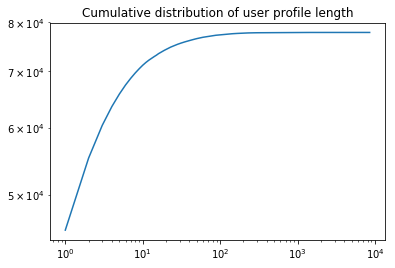

In [43]:
(explicit_data.userid.value_counts().value_counts().sort_index().cumsum()
              .plot(logy=True, logx=True, title='Cumulative distribution of user profile length'));

As you can see the number of users with more than 100 books in their preferences present a tiny fraction of the dataset. Let's filter them out as well as users with only a single preference.

In [44]:
users_pref_count = explicit_data['userid'].value_counts()
valid_users = (users_pref_count > 1) & (users_pref_count < 100)

In [45]:
valid_book_index = valid_books.index[valid_books]
valid_user_index = valid_users.index[valid_users]
sampled_data = explicit_data.query('isbn in @valid_book_index and userid in @valid_user_index')

Resulting data sparsity and the number of unique entities

In [46]:
unique_user_num = sampled_data.userid.nunique()
unique_books_num = sampled_data.isbn.nunique()
print(unique_user_num)
print(unique_books_num)
print(len(sampled_data) / (unique_books_num * unique_user_num))

30088
50751
0.00012824525323865794


# Appendix: functions for content-based model

In [48]:
from polara.lib.similarity import combine_similarity_data

In [49]:
meta_info = (bx_books_meta.query('isbn in @valid_book_index').set_index('isbn').fillna('')
                          .applymap(lambda x: x.split(',') if len(x) else [])
                          .reindex(sampled_data.isbn.unique(), fill_value=[])) # avoid missing isbn index in similarity data

In [50]:
meta_info.head()

,author,publisher
isbn,,
0060517794,[Rebecca Wells],[HarperTorch]
0671537458,[Terry McMillan],[Pocket]
0679776818,[Sebastian Faulks],[Vintage Books USA]
0380711524,[Joy Fielding],[Avon]
3453092007,[Dean Koontz],[Heyne]


## Different ways to build similarity matrix

### Weighted similarity

In [51]:
jw = 'jaccard-weighted'
jd = 'jaccard'
cs = 'cosine'
tc = 'tfidf-cosine'

sim_type = {'publisher':cs, 'author':cs}
item_similarity = combine_similarity_data(meta_info[list(sim_type.keys())], similarity_type=sim_type, weights=None)

In [52]:
item_similarity

<50751x50751 sparse matrix of type '<class 'numpy.float64'>'
	with 14358235 stored elements in Compressed Sparse Column format>

### All-at-once similarity

In [53]:
from polara.lib.similarity import get_similarity_data

In [54]:
all_features = meta_info.author.combine(meta_info.publisher, lambda x, y: x+y).to_frame('all_features')

In [55]:
all_similarity = get_similarity_data(all_features, similarity_type=tc)['all_features']
all_similarity

<50751x50751 sparse matrix of type '<class 'numpy.float64'>'
	with 14359687 stored elements in Compressed Sparse Column format>

## Preparing data model

Let's first define a new data model with the necessary functionality.

In [56]:
from polara import RecommenderData
from polara.recommender.coldstart.data import FeatureSimilarityMixin

In [57]:
# new class to mix in the similarity data
class SimilarityDataModel(FeatureSimilarityMixin, RecommenderData): 
    pass

In [58]:
similarities = {'userid': None, 'isbn': item_similarity}
sim_indices = {'userid': None, 'isbn': meta_info.index}

In [59]:
data_model = SimilarityDataModel(similarities, sim_indices,
                                 sampled_data, 'userid', 'isbn', 'rating',
                                 seed=42) 

In [60]:
data_model.random_holdout = True
data_model.holdout_size = 3
data_model.warm_start = True
switch_positive = 7
data_model.prepare()

Preparing data...
2587 unique isbn's within 2883 testset interactions were filtered. Reason: not in the training data.
1638 unique isbn's within 1749 holdout interactions were filtered. Reason: not in the training data.
3356 of 5814 userid's were filtered out from holdout. Reason: incompatible number of items.
621 userid's were filtered out from holdout. Reason: inconsistent with testset.
720 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 156787 events in the training and 5511 events in the holdout.


In [61]:
data_model.item_similarity

Updating isbn similarity matrix


<46850x46850 sparse matrix of type '<class 'numpy.float64'>'
	with 12463416 stored elements in Compressed Sparse Column format>

In [62]:
from polara import RecommenderModel

def informedness(score):
    return score.recall-score.fallout

class ContentBased(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(ContentBased, self).__init__(*args, **kwargs)
        self.method = "CB"
    
    def build(self, *args, **kwargs):
        self.data.item_similarity.setdiag(0) # get the name of the column, that corresponds to movieid
        
        
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        test_matrix, slice_data = self.get_test_matrix(test_data, shape, (start, stop))
        scores = test_matrix.dot(self.data.item_similarity)
        return scores, slice_data


In [63]:
contentbased = ContentBased(data_model)

In [64]:
recs = contentbased.get_recommendations()

In [79]:
from polara.lib.optimize import sgd_step
from math import sqrt
import numpy as np

In [80]:
def unbiased_sgdmf(user_idx, item_idx, feedback,
                   rank=10, lrate=0.005, reg=0.05,
                   num_epochs=25, tol=1e-4,
                   seed=None, verbose=True,
                   folding_in=False, Q=None):
    
    '''The main function to iterate over epochs in SGD approach.
    '''
    n_users = user_idx.max() + 1
    n_items = item_idx.max() + 1
    
    # initialization with random numbers
    random_state = np.random.RandomState(seed) if seed else np.random
    P = random_state.normal(scale=0.1, size=(n_users, rank))
    if not folding_in:
        Q = random_state.normal(scale=0.1, size=(n_items, rank))
        
    last_err = np.finfo(np.float64).max
    for epoch in range(num_epochs):
        # make a single SGD step
        if folding_in:
            new_err = sgd_folding_step(user_idx, item_idx, feedback, P, Q, lrate, reg)
        else:
            new_err = sgd_step(user_idx, item_idx, feedback, P, Q, lrate, reg)
        
        # control the progress by calculating error
        err_delta = abs(last_err - new_err) / last_err
        
        if verbose:
            rmse = sqrt(new_err / len(feedback))
            print('Epoch {} RMSE: {}'.format(epoch+1, rmse))
        
        last_err = new_err
        if err_delta < tol:
            break
    return P, Q

In [81]:
def sgd_folding_step(users_idx, items_idx, feedbacks, P, Q, eta, lambd):
    cum_error = 0
    for k, a in enumerate(feedbacks):
        i = users_idx[k]
        j = items_idx[k]

        pi = P[i, :]
        qj = Q[j, :]

        e = a - np.dot(pi, qj)

        new_pi = pi + eta * (e*qj - lambd*pi)

        P[i, :] = new_pi

        cum_error += e*e
    return cum_error

In [82]:
class SGDMatrixFactorization(RecommenderModel):
    '''This is a full implementation of the basic
    matrix factorization based on stochastic gradient descent.
    It uses folding-in approach to recommend items for test users.'''
    
    def __init__(self, *args, **kwargs):
        super(SGDMatrixFactorization, self).__init__(*args, **kwargs)
        self.rank = 10
        self.lrate = 0.005 # learning rate
        self.reg = 0.05 # regularization constant
        self.num_epochs = 25
        self.tol = 1e-4
        self.verbose = True
        self.seed = 0
        self.method = 'SGD-MF'
        self.factors = dict.fromkeys(self.data.fields[:2]) # for user and item factors
    
    def build(self):
        userid, itemid, feedback = self.data.fields
        
        trainset = self.data.training.sample(frac=1, random_state=self.seed) # shuffle data
        useridx = trainset[userid].values
        itemidx = trainset[itemid].values
        feedback = trainset[feedback].values
        # sgd learning parameters
        config = dict(rank=self.rank,
                      lrate=self.lrate,
                      reg=self.reg,
                      num_epochs=self.num_epochs,
                      tol=self.tol,
                      seed=self.seed,
                      verbose=self.verbose)
        # performing sgd
        user_factors, item_factors = unbiased_sgdmf(useridx, itemidx, feedback,
                                                    **config)
        # store learned factor matrices
        self.factors[userid] = user_factors
        self.factors[itemid] = item_factors
    
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        test_matrix, slice_data = self.get_test_matrix(test_data, shape, (start,stop))
        
        Q = self.factors[self.data.fields.itemid]
        
        config = dict(rank=self.rank,
                      lrate=self.lrate,
                      reg=self.reg,
                      num_epochs=self.num_epochs,
                      tol=self.tol,
                      seed=self.seed,
                      verbose=self.verbose)

        useridx, itemidx, feedback = slice_data
        
        p,q = unbiased_sgdmf(useridx, itemidx, feedback,
                            **config, folding_in=True, Q=Q)
                
        scores = p.dot(q.T)
        
        return scores, slice_data

In [83]:
from polara.evaluation.pipelines import find_optimal_svd_rank, find_optimal_config, random_grid, evaluate_models
from tqdm import tqdm_notebook

In [84]:
from polara.recommender.models import SVDModel
import matplotlib.pyplot as plt

In [91]:
svd = SVDModel(data_model)
svd_min_rank = 300
svd_max_rank= 350
svd_step = 2
dummy_params = {"1":[1]}

In [92]:
svd_rank, svd_score = find_optimal_svd_rank(svd, range(svd_min_rank, svd_max_rank,svd_step), informedness,
                                              return_scores=True, verbose=True, ranger=tqdm_notebook,
                                              switch_positive=switch_positive)

PureSVD training time: 77.89448555100012s


In [103]:
svd_best_score = svd_score[svd_rank]

In [93]:
dummy_params = {"1":[1]}
con_param, con_score = find_optimal_config(contentbased, *random_grid(dummy_params), target_metric=informedness,  
                                return_scores=True, verbose=True, ranger=tqdm_notebook,
                                switch_positive=switch_positive)

In [94]:
con_best_score = con_score[con_param]

In [95]:
mf_model = SGDMatrixFactorization(data_model)
mf_model.build()
mf_model.get_recommendations()

Epoch 1 RMSE: 7.823338127967977
Epoch 2 RMSE: 7.815191786013244
Epoch 3 RMSE: 7.804370385574205
Epoch 4 RMSE: 7.7843525161844935
Epoch 5 RMSE: 7.732819646089852
Epoch 6 RMSE: 7.594917619675917
Epoch 7 RMSE: 7.333223557637691
Epoch 8 RMSE: 6.979373194706189
Epoch 9 RMSE: 6.581711491274786
Epoch 10 RMSE: 6.175884982179125
Epoch 11 RMSE: 5.78187740640107
Epoch 12 RMSE: 5.409929446619358
Epoch 13 RMSE: 5.064603166297924
Epoch 14 RMSE: 4.746882872211445
Epoch 15 RMSE: 4.455783469945883
Epoch 16 RMSE: 4.189439386047139
Epoch 17 RMSE: 3.94566841719236
Epoch 18 RMSE: 3.7222312691293453
Epoch 19 RMSE: 3.5169830724718323
Epoch 20 RMSE: 3.327974467911102
Epoch 21 RMSE: 3.153482864743934
Epoch 22 RMSE: 2.991999060058695
Epoch 23 RMSE: 2.8422089236730526
Epoch 24 RMSE: 2.7029770346661097
Epoch 25 RMSE: 2.5733243227217097
Epoch 1 RMSE: 6.765393820344572
Epoch 2 RMSE: 5.381935947587145
Epoch 3 RMSE: 4.711639638574168
Epoch 4 RMSE: 4.296795007545764
Epoch 5 RMSE: 4.011683614828194
Epoch 6 RMSE: 3.8032

array([[29191,  7308, 11465, ..., 43943, 45904, 19360],
       [ 2783, 30163, 28674, ...,  2246,  3280, 29692],
       [ 8919, 36081, 18655, ...,  3664, 24145,  8492],
       ...,
       [28674,  1556, 30163, ...,  7344,  2783, 10992],
       [16964,  2783, 13573, ...,  8063, 28393, 14600],
       [ 1556, 25898,  8463, ...,  1542,  5297, 28921]])

In [96]:
mf_params = {'rank': range(320,400,2),
            'lrate': [0.003, 0.001],
            'reg': [0.03, 0.3],
            'num_epochs':[40, 60, 80],
            'tol': [1e-3]
            }
mf_param, mf_score = find_optimal_config(mf_model, *random_grid(mf_params, n=60), target_metric=informedness,  
                                         return_scores=True, ranger=tqdm_notebook, force_build=True,
                                         switch_positive=switch_positive)

In [97]:
mf_best_score = mf_score.max()

In [104]:
print(svd_best_score)
print(mf_best_score)
print(con_best_score)

0.03556523317002359
0.033932135728542916
0.03139176193068409
